In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import OneHotEncoder

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform, randint

from sklearn.preprocessing import StandardScaler
import pickle

from sklearn.metrics import r2_score

- Import data.

In [2]:
epi = pd.read_csv('../data/dataframes/epi_cleaned.csv')
epi.drop(columns = 'Unnamed: 0', inplace = True)

- Drop columns that are a combination of other features.

In [3]:
precomputed = ['Ecosystem Vitality', 'Environmental Health', 'Air Quality', 'Sanitation & Drinking Water', 'Biodiversity & Habitat']

In [4]:
epi.drop(columns = precomputed, inplace = True)

- Multi-index country and year.

In [5]:
years = sorted(set(epi['year'].values))
min_year = years[0]
max_year = years[-1]

In [6]:
epi.set_index(['country_name', 'year'], inplace = True)

- Model OLS, LASSO, Ridge per year.

In [7]:
x_list = epi.columns.tolist()
x_list.remove('Environmental Performance Index')

In [8]:
def quick_ttt(df):
    X = df[x_list]
    y = df['Environmental Performance Index']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    return X_train, X_test, y_train, y_test

In [9]:
%%capture
models = {}
for year in range(min_year, max_year + 1):
    year_frame = epi.loc[(slice(None), year), :]
    year_models = {}
    
    X_train, X_test, y_train, y_test = quick_ttt(year_frame)
    
    #OLS
    lr = LinearRegression(n_jobs = 8)
    lr.fit(X_train, y_train)
    
    train_preds = lr.predict(X_train)
    test_preds = lr.predict(X_test)
    
    year_models['OLS'] = {'model': lr, 'train_score': r2_score(y_train, train_preds), 'test_score': r2_score(y_test, test_preds)}
    
    sc = StandardScaler()
    
    Xs_train = sc.fit_transform(X_train)
    Xs_test = sc.transform(X_test)
    
    #LASSO    
    lasso = Lasso(random_state = 42, selection = 'random')
    
    lasso_pipe_params = {
        'alpha': loguniform(.001, 100),
        'tol': loguniform(.00001, .001),
        'max_iter': uniform(100, 10000)
    }
    
    lasso_bs = RandomizedSearchCV(lasso, param_distributions = lasso_pipe_params, 
                             cv = 5, n_jobs = 8, random_state = 42)
    
    lasso_bs.fit(Xs_train, y_train)
    
    lasso_train_preds = lasso_bs.predict(Xs_train)
    lasso_test_preds = lasso_bs.predict(Xs_test)
    
    year_models['LASSO'] =  {'model': lasso_bs.best_estimator_, 'train_score': r2_score(y_train, lasso_train_preds), 'test_score': r2_score(y_test, lasso_test_preds)}
    
    #Ridge
    ridge = Ridge(random_state = 42)
    
    ridge_pipe_params = {
        'alpha': loguniform(.001, 100),
        'tol': loguniform(.00001, .001),
        'max_iter': uniform(100, 10000)
    }
    
    ridge_bs = RandomizedSearchCV(ridge, param_distributions = ridge_pipe_params, cv = 5, n_jobs = 8, random_state = 42)
    ridge_bs.fit(Xs_train, y_train)
    
    ridge_train_preds = ridge_bs.predict(Xs_train)
    ridge_test_preds = ridge_bs.predict(Xs_test)
    
    year_models['Ridge'] =  {'model': ridge_bs.best_estimator_, 'train_score': r2_score(y_train, ridge_train_preds), 'test_score': r2_score(y_test, ridge_test_preds)}
    
    models[year] = year_models

- Make dataframe for model coefficients

In [10]:
indices = []
for model in list(year_models.keys()):
    for year in range(min_year, max_year + 1):   
        indices.append((model, year))

In [11]:
linear_cols = x_list.copy()
linear_cols.extend(['train_r2', 'test_r2'])

In [12]:
linear_frame = pd.DataFrame(columns = linear_cols, index = pd.MultiIndex.from_tuples(indices, names=["model", "year"]))

- Fill model coefficient dataframe

In [13]:
for model in list(year_models.keys()):
    for year in range(min_year, max_year + 1):     
        pairs = zip(x_list, list(models[year][model]['model'].coef_))
        pairs = {key: value for key, value in pairs}
        pairs['train_r2'] = models[year][model]['train_score']
        pairs['test_r2'] = models[year][model]['test_score']
        
        linear_frame.loc[(model, year)] = pd.Series(pairs)

- Determine which models to plot.

In [14]:
linear_frame['delta'] = linear_frame['train_r2'] - linear_frame['test_r2']

In [15]:
r2s = linear_frame[['train_r2', 'test_r2', 'delta']].copy()

In [16]:
r2s.loc[('OLS', slice(None)), :].mean(), r2s.loc[('OLS', slice(None)), :].std()

(train_r2    0.945851
 test_r2     0.937986
 delta       0.007865
 dtype: float64,
 train_r2    0.011908
 test_r2     0.010023
 delta       0.005579
 dtype: float64)

In [17]:
r2s.loc[('LASSO', slice(None)), :].mean(), r2s.loc[('LASSO', slice(None)), :].std()

(train_r2    0.944281
 test_r2     0.939030
 delta       0.005251
 dtype: float64,
 train_r2    0.012040
 test_r2     0.010139
 delta       0.005649
 dtype: float64)

In [18]:
r2s.loc[('Ridge', slice(None)), :].mean(), r2s.loc[('Ridge', slice(None)), :].std()

(train_r2    0.944646
 test_r2     0.940990
 delta       0.003656
 dtype: float64,
 train_r2    0.012043
 test_r2     0.009378
 delta       0.005937
 dtype: float64)

- By these numbers, Ridge is our best model in terms of overfit and testing r2.

In [19]:
linear_frame.drop(columns = ['train_r2', 'test_r2', 'delta'], inplace = True)

- Plot best model weights

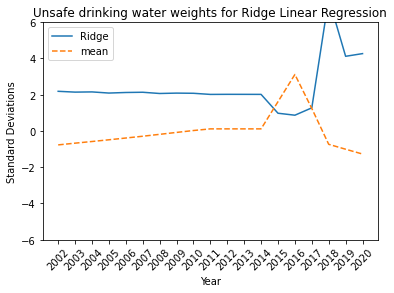

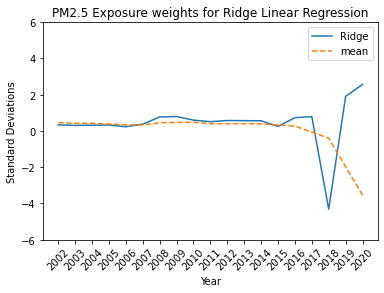

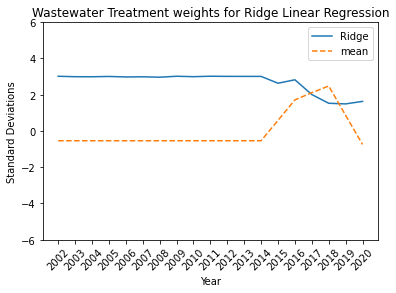

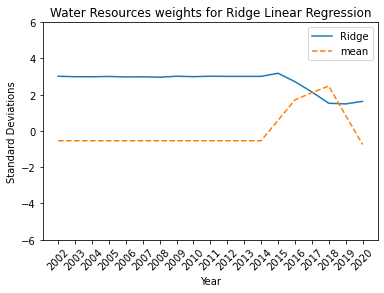

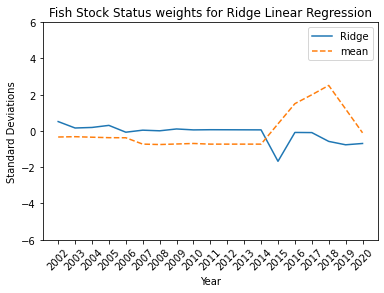

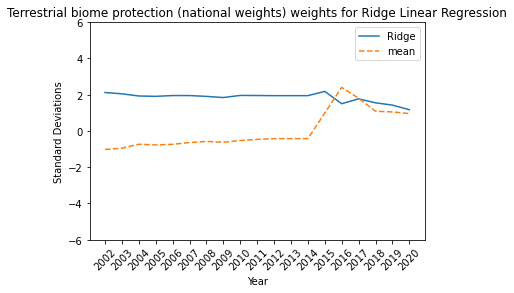

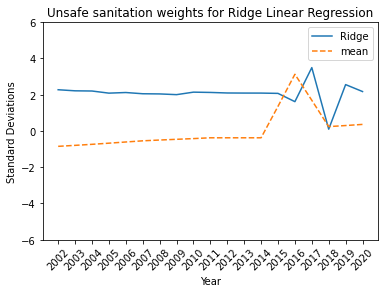

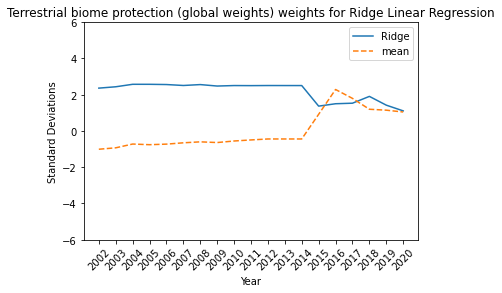

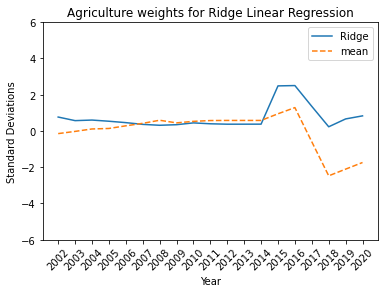

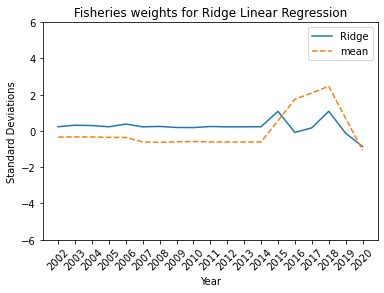

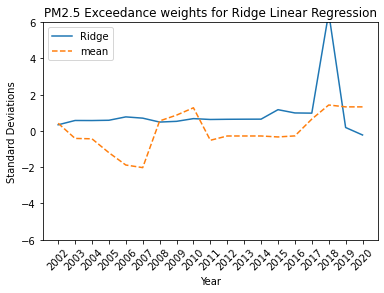

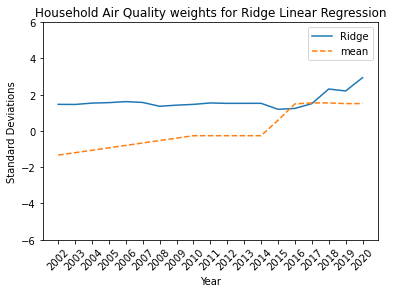

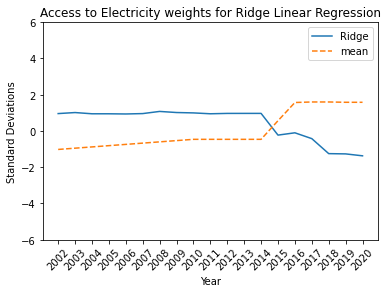

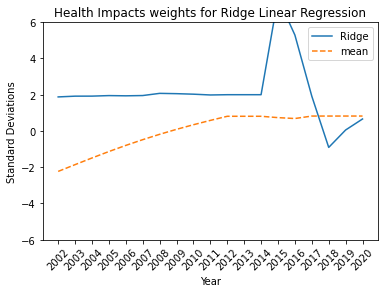

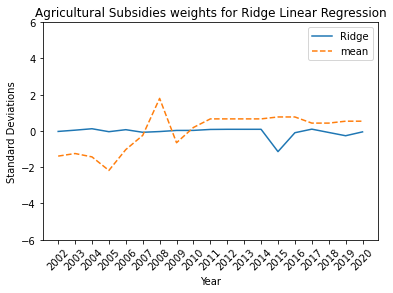

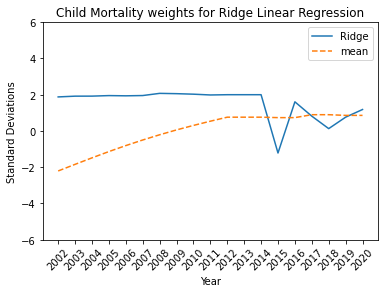

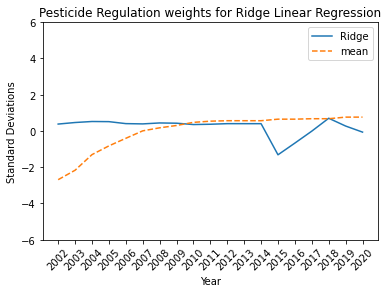

In [37]:
model_names = list(year_models.keys())

years = range(min_year, max_year + 1)

for col in x_list:
    year_slice = linear_frame.loc['Ridge', col]
    
    if year_slice.map(abs).max() > 1:
    
        plt.plot(years, year_slice)

        means = []
        for year in years:
            means.append(epi.loc[(slice(None), year), :][col].mean())

        plt.plot(years, sc.fit_transform(np.array(means).reshape(-1,1)), '--')

        legend = ['Ridge']
        legend.append('mean')

        plt.title(f'{col} weights for Ridge Linear Regression')
        plt.xlabel('Year')
        plt.ylabel('Standard Deviations')
        plt.xticks(ticks = years, rotation = 45)
        plt.legend(legend)

        #credit to: https://stackoverflow.com/questions/3777861/setting-y-axis-limit-in-matplotlib
        x1,x2,y1,y2 = plt.axis()  
        plt.axis((x1,x2,-6,6))
    
        plt.savefig(f'images/RidgeLinearRegressionOverTime/Ridge_{col}.png')
        plt.show()

- Model Decision Tree, Random Forest, and Extra Trees

In [25]:
%%capture
tree_models = {}
for year in range(min_year, max_year + 1):
    year_frame = epi.loc[(slice(None), year), :]
    year_models = {}
    
    X_train, X_test, y_train, y_test = quick_ttt(year_frame)
    
    #Dtree
    dtree = DecisionTreeRegressor(random_state = 42, max_features = 'sqrt')
    
    dtree_pipe_params = {
            'max_depth': randint(1, 30),
            'min_samples_split': uniform(0, .1),
            'min_samples_leaf': uniform(0, .1),
            'min_weight_fraction_leaf': loguniform(0.0001, .2),
            'min_impurity_decrease': loguniform(0.0001, .1),
            'min_impurity_split': loguniform(0.0001, .1),
            'ccp_alpha': loguniform(0.000001, .1),
    }

    dtree_bs = RandomizedSearchCV(dtree, param_distributions =dtree_pipe_params, 
                                 cv = 5, n_jobs = 8, random_state = 42)

    dtree_bs.fit(X_train, y_train)
    dtree_bs.fit(X_train, y_train)
    
    train_preds =dtree_bs.predict(X_train)
    test_preds =dtree_bs.predict(X_test)
    
    year_models['DTree'] = {'model':dtree_bs.best_estimator_, 'train_score': r2_score(y_train, train_preds), 'test_score': r2_score(y_test, test_preds)}
 
    
    #Random Forest
    rf = RandomForestRegressor(random_state = 42, bootstrap = True)
    
    rf_pipe_params = {
            'n_estimators': randint(400, 800),
            'min_samples_split': uniform(0, .1),
            'min_samples_leaf': uniform(0, .1),
            'min_weight_fraction_leaf': loguniform(0.0001, .2),
            'min_impurity_decrease': loguniform(0.0001, .1),
            'min_impurity_split': loguniform(0.0001, .1),
            'ccp_alpha': loguniform(0.000001, .1),
            'max_samples': uniform(.8, 1)
    }
    
    rf_bs = RandomizedSearchCV(rf, param_distributions = rf_pipe_params, 
                             cv = 5, n_jobs = 8, random_state = 42)
    
    rf_bs.fit(X_train, y_train)
    rf_bs.fit(X_train, y_train)
    
    train_preds = rf_bs.predict(X_train)
    test_preds = rf_bs.predict(X_test)
    
    year_models['RF'] = {'model': rf_bs.best_estimator_, 'train_score': r2_score(y_train, train_preds), 'test_score': r2_score(y_test, test_preds)}
  
    #Extra Trees
    et = ExtraTreesRegressor(random_state = 42, bootstrap = True)
    
    et_pipe_params = {
            'n_estimators': randint(400, 800),
            'min_samples_split': uniform(0, .1),
            'min_samples_leaf': uniform(0, .1),
            'min_weight_fraction_leaf': loguniform(0.0001, .2),
            'min_impurity_decrease': loguniform(0.0001, .1),
            'min_impurity_split': loguniform(0.0001, .1),
            'ccp_alpha': loguniform(0.000001, .1),
            'max_samples': uniform(.8, 1)
    }
    
    et_bs = RandomizedSearchCV(et, param_distributions = et_pipe_params, 
                             cv = 5, n_jobs = 8, random_state = 42)
    
    et_bs.fit(X_train, y_train)
    et_bs.fit(X_train, y_train)
    
    train_preds = et_bs.predict(X_train)
    test_preds = et_bs.predict(X_test)
    
    year_models['ET'] = {'model': et_bs.best_estimator_, 'train_score': r2_score(y_train, train_preds), 'test_score': r2_score(y_test, test_preds)}
 

    tree_models[year] = year_models

In [26]:
indices = []
for model in list(tree_models[min_year].keys()):
    for year in range(min_year, max_year + 1):   
        indices.append((model, year))

In [27]:
tree_cols = x_list.copy()
tree_cols.extend(['train_r2', 'test_r2'])

In [28]:
tree_frame = pd.DataFrame(columns = tree_cols, index = pd.MultiIndex.from_tuples(indices, names=["model", "year"]))

- Fill model feature importance dataframe.

In [29]:
for model_type in list(tree_models[min_year].keys()): 
    for year in list(tree_models.keys()):
        tree = tree_models[year][model_type]['model']
        
        features = zip(x_list, list(tree.feature_importances_))
        features = {feature: importance for feature, importance in features}
        features['train_r2'] = tree_models[year][model_type]['train_score']
        features['test_r2'] = tree_models[year][model_type]['test_score']
        
        tree_frame.loc[(model_type, year)] = pd.Series(features)

- Determine which models to plot.

In [30]:
tree_frame['delta'] = tree_frame['train_r2'] - tree_frame['test_r2']

In [31]:
r2s = tree_frame[['train_r2', 'test_r2', 'delta']].copy()

In [32]:
r2s.loc[('DTree', slice(None)), :].mean(), r2s.loc[('DTree', slice(None)), :].std()

(train_r2    0.910241
 test_r2     0.709387
 delta       0.200854
 dtype: float64,
 train_r2    0.028880
 test_r2     0.066687
 delta       0.073795
 dtype: float64)

In [33]:
r2s.loc[('RF', slice(None)), :].mean(), r2s.loc[('RF', slice(None)), :].std()

(train_r2    0.912981
 test_r2     0.873285
 delta       0.039696
 dtype: float64,
 train_r2    0.011500
 test_r2     0.022763
 delta       0.017102
 dtype: float64)

In [34]:
r2s.loc[('ET', slice(None)), :].mean(), r2s.loc[('ET', slice(None)), :].std()

(train_r2    0.885400
 test_r2     0.869769
 delta       0.015631
 dtype: float64,
 train_r2    0.012837
 test_r2     0.019639
 delta       0.010922
 dtype: float64)

- By these numbers, ET is our best model for consistent minimal overfit and predictive power almost equal to RF.

In [35]:
tree_frame.drop(columns = ['train_r2', 'test_r2', 'delta'], inplace = True)

- Plot best model feature importances.

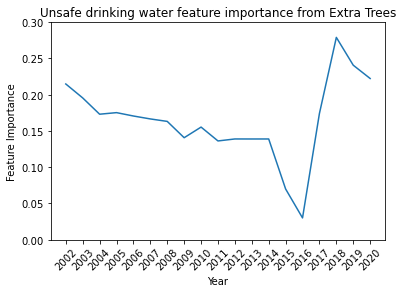

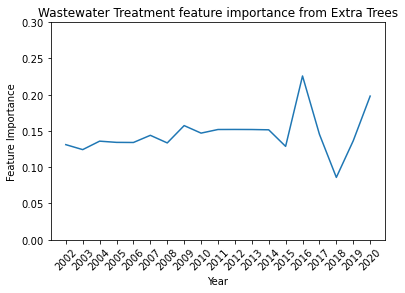

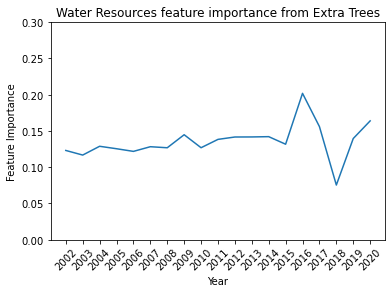

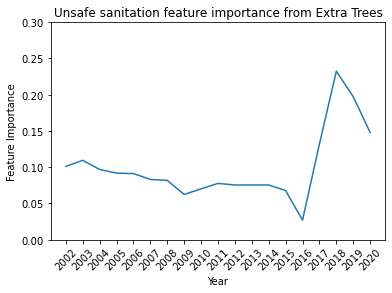

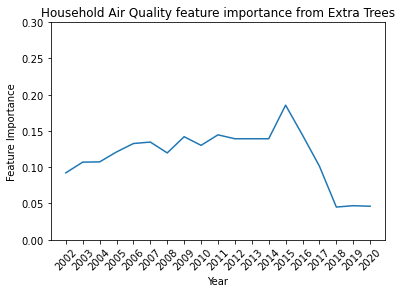

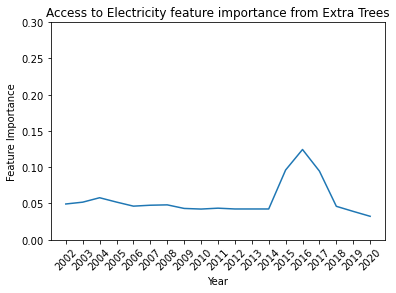

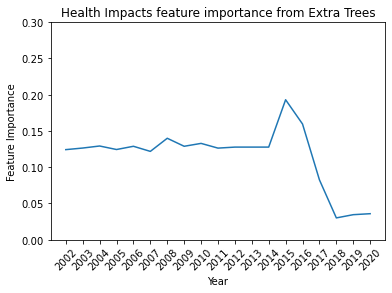

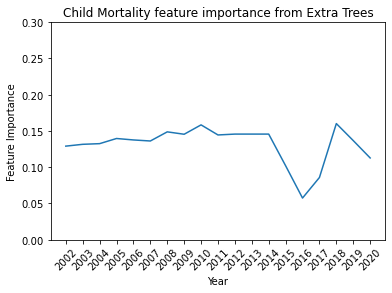

In [36]:
model_names = list(year_models.keys())

years = range(min_year, max_year + 1)

for col in x_list:
    year_slice = tree_frame.loc['ET', col]
    
    if year_slice.max() > .05:
        plt.plot(years, year_slice)

        plt.title(f'{col} feature importance from Extra Trees')
        plt.xlabel('Year')
        plt.ylabel('Feature Importance')
        plt.xticks(ticks = years, rotation = 45)

        #credit to: https://stackoverflow.com/questions/3777861/setting-y-axis-limit-in-matplotlib
        x1,x2,y1,y2 = plt.axis()  
        plt.axis((x1,x2,0,.3))

        plt.savefig(f'images/ExtraTreesOverTime/ET_{col}.png')
        plt.show()

- All images saved for later analysis. Moving to next notebook.